In [138]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import pandas as pd

import cobra
#import escher
 
%matplotlib inline

<h3> Loading the Ecoli models <h3>

In [139]:
from genericpath import isfile
import os

dir = 'data'
models = []

for filename in os.scandir(dir):
    f = os.path.join(filename)
    if filename.is_file():
        print(filename.name)
        models.append(cobra.io.read_sbml_model(f))
    
#cobra.io.read_sbml_model("./data/iEC1344_C.xml")
#model = cobra.io.load_model("textbook") 
# for i in models[0].reactions:
#     print(i)

iEcHS_1320.xml
iEC1344_C.xml
iEcDH1_1363.xml
iECS88_1305.xml
iECW_1372.xml


<h2> BiGG Model to Networkx Graph

In [140]:
tmodel = cobra.io.load_model('e_coli_core')
tmodel.optimize()

,fluxes,reduced_costs
PFK,7.477382,-1.387779e-17
PFL,0.000000,2.081668e-17
PGI,4.860861,0.000000e+00
PGK,-16.023526,6.938894e-18
PGL,4.959985,1.517883e-17
...,...,...
NADH16,38.534610,0.000000e+00
NADTRHD,0.000000,-2.546243e-03
NH4t,4.765319,-1.387779e-17
O2t,21.799493,0.000000e+00


In [141]:
pfk = tmodel.reactions.get_by_id('PFK')
#pfk.flux

In [142]:
rxns = {}#[]
mbls = set()#[]

"""TO DO:
- Add fluxes, aka weighted edges for metabolites: Stoichemetric, how many of each does it take/produce. Always an integer.
- Fix node font size
- Do with actual model not just ecoli_core
"""

for rxn in tmodel.reactions: 
    #rxns.add(rxn.id)
    #print(rxn)
    #add reactants
    reactants_list = []
    for i in rxn.reactants:
        reactants_list.append(i.id)
  #  print(reactants_list)
    products_list = []
    for i in rxn.products:
        products_list.append(i.id)
            
    rxns[rxn.id] = reactants_list, products_list

for mbl in tmodel.metabolites: mbls.add(mbl.id)#, print(mbl)
   
print(len(rxns))
#display(rxns)
print(len(mbls))
#display(mbls)


95
72


In [143]:
B = nx.DiGraph()
B.add_nodes_from(mbls, bipartite=1,)
B.add_nodes_from(rxns, bipartite=1)

In [144]:
"""Add edges for substrate, products to/out reactions"""
for name in rxns:
    subs, prods = rxns[name]
    for sub in subs:
        #print(sub)
        #ADD AN EDGE FROM SUBSTRATE TO REACTION. Where left hand side is metabolites and right is reactions
        B.add_edge(sub, name)
        
    for prod in prods:
        #ADD AN EDGE FROM REACTION TO PRODUCTS
        B.add_edge(name, prod)
        
    #B.add_edge()

#print(rxns)
#B.add_edge('PFK', '2pg_c')

<H3>Get interesting paths (highest degree, shortest, longest, biomass related) </h3>

In [158]:
#Select highest degree node in reactions and get path
#tmodel.reactions.get_by_id("BIOMASS_Ecoli_core_w_GAM")
max_degree = ('', 0)
for i in B.degree():
    if(i[0] in mbls):
    #print(i[0])
        if i[1] > max_degree[1]:
            max_degree = i
print(max_degree)

biomass_path = B.in_edges('BIOMASS_Ecoli_core_w_GAM')
#path_edges = list(zip(biomass_path,biomass_path[1:]))
short_path = nx.shortest_path(B, source='glu__L_c', target='nadp_c')

print(short_path)
#biomass_path.append(B.out_edges('BIOMASS_Ecoli_core_w_GAM'))
#print(short_path)

#
tmodel.reactions.get_by_id('BIOMASS_Ecoli_core_w_GAM').flux

paths = nx.all_simple_paths(B, 'h_c', 'atp_c', cutoff=12)
longest_path = []
for i in paths:
    if len(i) > len(longest_path):
        longest_path = i
    #
print(longest_path)

('h_c', 35)
['glu__L_c', 'BIOMASS_Ecoli_core_w_GAM', 'nadp_c']
['h_c', 'PYK', 'pyr_c', 'PFL', 'accoa_c', 'PTAr', 'coa_c', 'ACALD', 'nadh_c', 'NADH16', 'h_e', 'ATPS4r', 'atp_c']


In [146]:
def draw_bipartite(G,z, first_partition, input_path):
    # MODIFY THIS FUNCTION AS NEEDED
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : a circular layout plot (ignores edge weights)
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d67711','#11d646','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)

    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])])
    nsize  = 500
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
        
    #pos = nx.draw_networkx(G,edge_color='teal',with_labels=flabel,node_size=nsize,width=2,node_color=node_colors,pos = nx.bipartite_layout(G, nodes=first_partition))#pos = nx.circular_layout(G)) # draw it pretty
    nx.draw(G,edge_color='teal',with_labels=flabel,node_size=nsize,width=2,node_color=node_colors, pos = nx.bipartite_layout(G, nodes=first_partition))
    pos = nx.bipartite_layout(G, nodes=first_partition)
    path_edges = list(zip(input_path, input_path[1:]))
    #path_edges = input_path
    print(path_edges)
    nx.draw_networkx_edges(G, pos=pos, edgelist=path_edges, edge_color='purple',width=4)
    limits=plt.axis('off')                                      # turn off axes 
    plt.show() 

    return

In [147]:
#Z is dictionary of partitions
z = {}
for rxn in rxns:
    z[rxn] = 1
for met in mbls:
    z[met] = 0
#display(z)

[('h_c', 'PYK'), ('PYK', 'pyr_c'), ('pyr_c', 'PFL'), ('PFL', 'accoa_c'), ('accoa_c', 'PTAr'), ('PTAr', 'coa_c'), ('coa_c', 'ACALD'), ('ACALD', 'nadh_c'), ('nadh_c', 'NADH16'), ('NADH16', 'h_e'), ('h_e', 'ATPS4r'), ('ATPS4r', 'atp_c')]


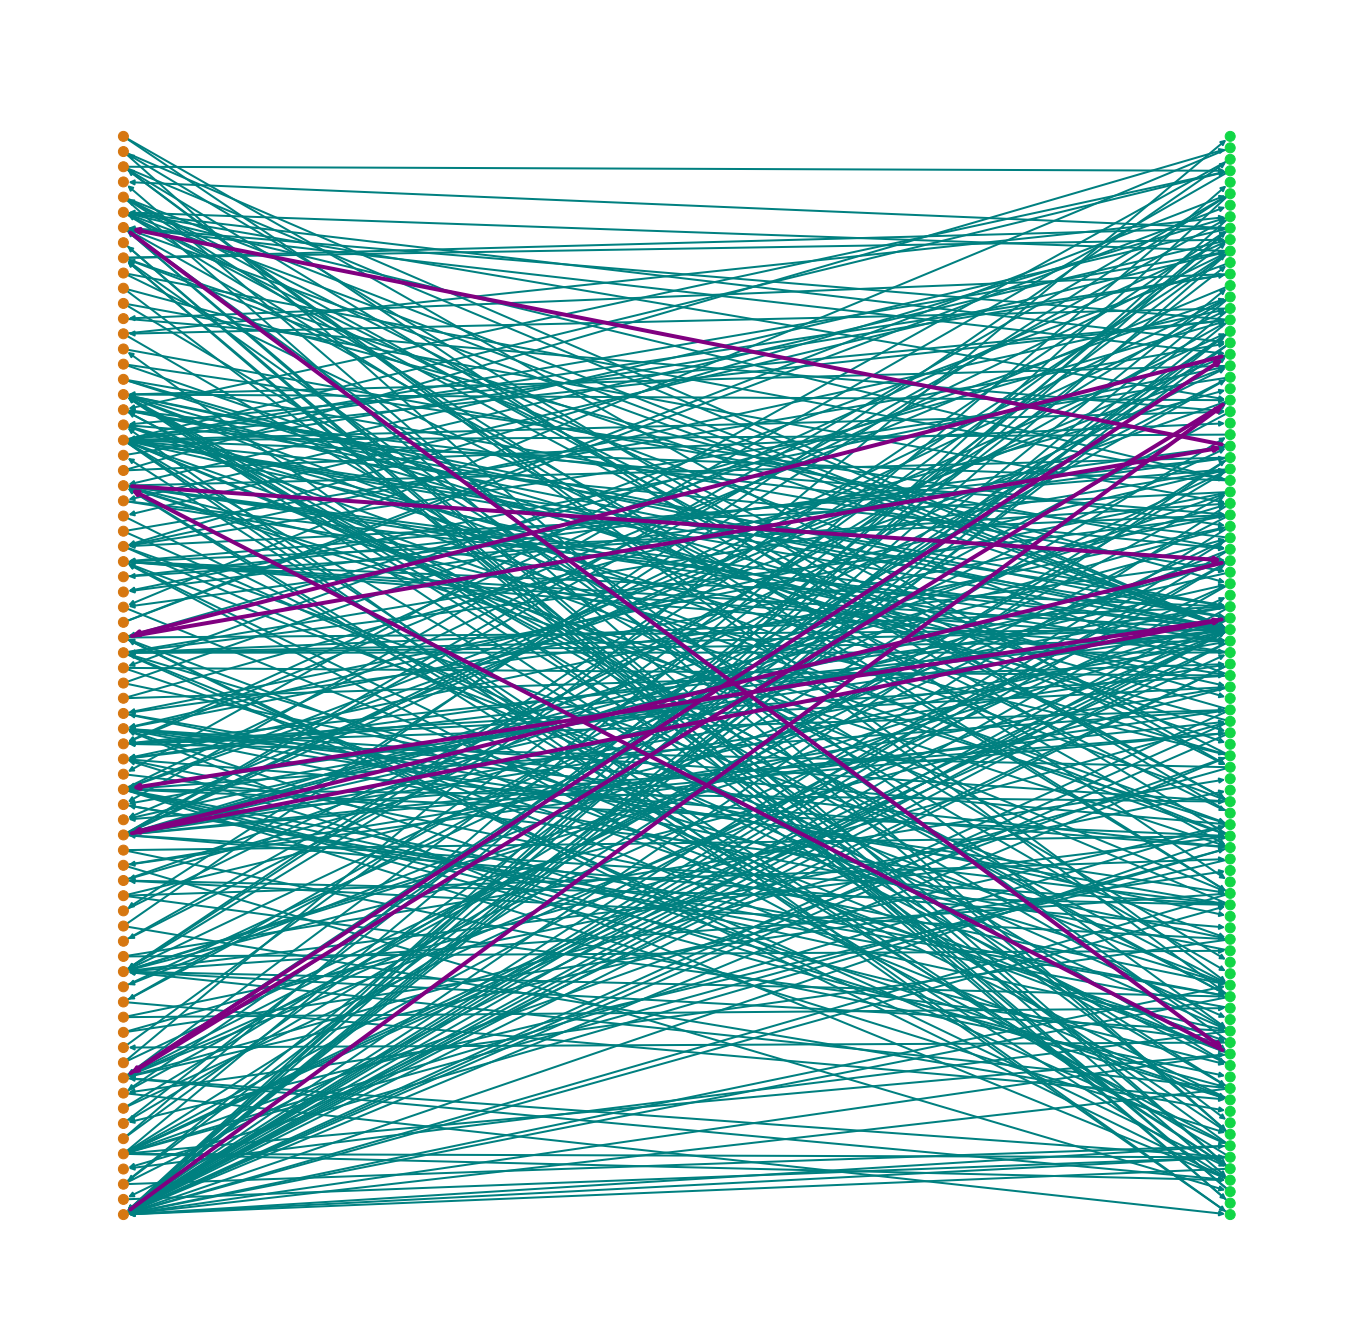

In [148]:
#nx.draw_networkx(B, width=1)
plt.figure(3,figsize=(24,24)) 
plt.title('E. Coli Core Metabolism, Orange nodes: metabolites, Green: reactions ', color='w')

draw_bipartite(B, z, mbls, input_path=longest_path)
plt.show()

<H3> Reaction knock out </h3>

In [149]:
test = cobra.io.load_model('e_coli_core')
print(test)
for rxn in test.reactions:
    if rxn.id == 'PFK':
        print(rxn.id)
 
#print(test.reactions)
test.reactions[0]
#print(test.reactions)

e_coli_core
PFK


Reaction identifier,PFK
Name,Phosphofructokinase
Memory address,0x7f7e3820be80
Stoichiometry,"atp_c + f6p_c --> adp_c + fdp_c + h_c ATP C10H12N5O13P3 + D-Fructose 6-phosphate --> ADP C10H12N5O10P2 + D-Fructose 1,6-bisphosphate + H+"
GPR,b3916 or b1723
Lower bound,0.0
Upper bound,1000.0


In [150]:
for i in models:
    print(i.objective)

Maximize
1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Maximize
1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Maximize
1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Maximize
1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Maximize
1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1


In [151]:
test2 = models[0]

test2.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M").objective_coefficient = 0
test2.reactions.get_by_id("BIOMASS_Ec_iJO1366_WT_53p95M").objective_coefficient = 1.0

# Set constrants for aerobic growth in glucose minimal media
# NB: that these reaction names are different than in the tutorial
test2.reactions.get_by_id("EX_glc__D_e").lower_bound = -10
test2.reactions.get_by_id("EX_o2_e").lower_bound = -15

"""New code: """

#test2.reactions.PFK.knock_out()
#test2.reactions.PFK.lower_bound = -10
#test2.reactions.PFK.lower_bound = -10

#model.reactions.get_by_id("EX_glc__D_e").knock_out()
#model.reactions.PGM.knock_out()

#model.reactions.PYRT2.knock_out()
#model.reactions.PYRt2.knock_out()
test2.reactions.PGM.knock_out()

#model.reactions.CYTBD.knock_out()
# Solve
solution = test2.optimize()

# Output solution
print(f'Growth Rate: '+str(solution.objective_value)+' 1/h')

# Write out the solution.fluxes data as a csv so that we can import it into an Escher visualization
#df = pd.DataFrame.from_dict([solution.fluxes]).T
#df.to_csv('FBA_max_biomass_noFUM.csv')

# Output more information
test2.summary()

Growth Rate: 0.0 1/h


Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,0.1482,6,100.00%
o2_e,EX_o2_e,0.8894,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-0.8894,1,100.00%
h2o_e,EX_h2o_e,-0.8894,0,0.00%


In [152]:
#obj_df = pd.DataFrame(columns=[models])   

#RESET MODELS HERE:
ecoli_models = models

model_dict = {}

for ecoli in ecoli_models:
    #Set object 
  ecoli.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M").objective_coefficient = 0
  ecoli.reactions.get_by_id("BIOMASS_Ec_iJO1366_WT_53p95M").objective_coefficient = 1.0

  rxn_ids = ['PFK', 'PFL', 'PGM', 'PYRt2' ,'PGL', 'PPS', 'EX_ac_e', 'DM_amob_c']
  i = 0
  sol_dict = {}
  ecoli.reactions.get_by_id("EX_o2_e").lower_bound = -15
  ecoli.reactions.get_by_id("EX_glc__D_e").lower_bound = -10
    
  for rxn in ecoli.reactions:    
    if (rxn.id == rxn_ids[i]) and (i != len(rxn_ids) - 1):
      i += 1
            #ecoli.reactions.rxn.knock_out()
          #  print(rxn.id)
      rxn.knock_out()
      solution = ecoli.optimize()
      sol_dict[rxn.id] = solution.objective_value
            #obj_df[rxn, ecoli] = 0
            #obj_df.loc[rxn].ecoli = 1
      print(ecoli, ' knock out ', rxn.id , ' Growth Rate: ' , str(solution.objective_value), ' 1/h')
    #obj_df.append(sol_dict,ignore_index=True)
    #print("Solution dict", sol_dict)
  model_dict[ecoli.id] = sol_dict
  #Maybe reset all parameters
    
#print(model_dict)
obj_df = pd.DataFrame(model_dict)
obj_df


iEcHS_1320  knock out  PFK  Growth Rate:  0.0  1/h
iEcHS_1320  knock out  PFL  Growth Rate:  -2.5022486767021083e-17  1/h
iEcHS_1320  knock out  PGM  Growth Rate:  -2.5022486767021083e-17  1/h
iEC1344_C  knock out  PFK  Growth Rate:  6.312341605276005e-31  1/h
iEC1344_C  knock out  PFL  Growth Rate:  6.312341605276005e-31  1/h
iEC1344_C  knock out  PGM  Growth Rate:  0.0  1/h
iEcDH1_1363  knock out  PFK  Growth Rate:  0.0  1/h
iEcDH1_1363  knock out  PFL  Growth Rate:  0.0  1/h
iEcDH1_1363  knock out  PGM  Growth Rate:  0.0  1/h
iECS88_1305  knock out  PFK  Growth Rate:  0.0  1/h
iECS88_1305  knock out  PFL  Growth Rate:  0.0  1/h
iECS88_1305  knock out  PGM  Growth Rate:  0.0  1/h
iECW_1372  knock out  PFK  Growth Rate:  0.0  1/h
iECW_1372  knock out  PFL  Growth Rate:  0.0  1/h
iECW_1372  knock out  PGM  Growth Rate:  -2.56632405124232e-18  1/h


,iEcHS_1320,iEC1344_C,iEcDH1_1363,iECS88_1305,iECW_1372
PFK,0.000000e+00,6.312342e-31,0.0,0.0,0.000000e+00
PFL,-2.502249e-17,6.312342e-31,0.0,0.0,0.000000e+00
PGM,-2.502249e-17,0.000000e+00,0.0,0.0,-2.566324e-18


<AxesSubplot:>

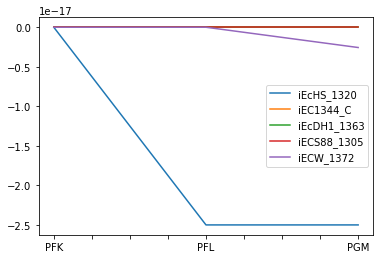

In [153]:
obj_df.plot()

#Question: best way to represent data in graph form to illustate knockout differences?
#Question convert the Bigg Model to a networkx graph to do more networky types of experiments?
#https://gitter.im/opencobra/cobrapy?at=5d223634631d3433ba416891

<h3> Notes </h3>

rxn_ids = ['PFK', 'PFL', 'PGM', 'PYRt2' ,'PGL', 'PPS', 'EX_ac_e', 'DM_amob_c']

- Best way to represent data in graph form to illustate knockout differences?
    What am I trying to say? What is the goal?

- Convert the Bigg Model to a networkx graph to do more networky types of experiments?

- Any way to undo knock outs? Seems to be affecting the model even after restarting.
    Consider targeting parts of the metabolic network. As a function of the network statistics. Knockout highest degree. Clustering Coefficient. Centrality Measurements. 
    Degree is a bad way to kill Ecoli. What is most effective piece of network to target. Don't use ER graph. 

    parse text of output metabolites. Can turn it into a network.
    
Find out what is causing persistent state.


We want to maximize the objective function (Biomass for all Ecoli) by optimizing the model given that certain reactions are knocked out.

"Metabolic flux analysis of E. coli knockouts: lessons from the Keio collection and future outlook":

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5842030/

<h2> Changing growth media experiments:

In [154]:
# with model: 
#     new_medium = model.medium
#     new_medium['EX_h2o_e'] = 0.01
#     model.medium = new_medium
#     print(model.slim_optimize())
#     print(model.medium)
# #model.medium

# medium = model.medium
# medium["EX_o2_e"] = 0.0
# model.medium = medium

# model.medium

In [155]:
# def read_json_file(filename):
#     with open(filename) as f:
#         js_graph = json.load(f)
#     return nx.node_link_graph(js_graph)

# read_json_file('./data/iEcHS_1320.json')
#nx.read_gml('./data/iEC1344_C.xml')
# nx.read_graphml("./data/iEcHS_1320.xml")

In [156]:
# import scipy as sc

# path = 'file.mat'

# raw_data = sc.loadmat(path, squeeze_me=True)

# data = raw_data['data_struct']